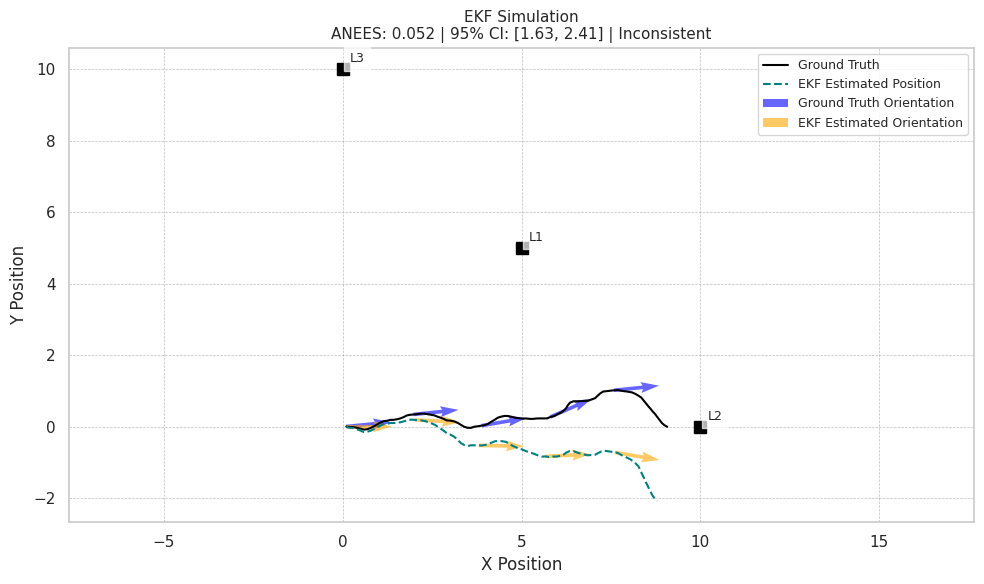

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2

# Use seaborn styling
sns.set_context("notebook")
sns.set_style("whitegrid")

# Configuration
config = {
    'wheel_base': 0.5,
    'wheel_diameter': 0.1,
    'time_steps': 100,
    'landmarks': [(5, 5), (10, 0), (0, 10)],
    'motion_noise': {'DL': 0.01, 'DR': 0.01},
    'sensor_noise': {'Drho': 0.1, 'Dphi': 0.05},
    'seed_motion': 42,
    'seed_sensor': 123,
    'initial_pose': (0.0, 0.0, 0.0)
}

rng_motion = np.random.default_rng(config['seed_motion'])

def motion_model(x, u, b):
    dl, dr = u
    d = (dl + dr) / 2.0
    theta = x[2]
    theta_new = theta + (dr - dl) / b
    theta_new = np.arctan2(np.sin(theta_new), np.cos(theta_new))
    x_new = x[0] + d * np.cos(theta_new)
    y_new = x[1] + d * np.sin(theta_new)
    return np.array([x_new, y_new, theta_new])

def jacobian_F(theta, dl, dr, b):
    d = (dl + dr) / 2.0
    dtheta = (dr - dl) / b
    theta_new = theta + dtheta
    Fx = np.array([
        [1, 0, -d * np.sin(theta_new)],
        [0, 1,  d * np.cos(theta_new)],
        [0, 0, 1]
    ])
    return Fx

x_actual = np.array(config['initial_pose'])
x_est = np.array(config['initial_pose'])
P = np.eye(3) * 0.01
data_log = []

for t in range(config['time_steps']):
    turn_bias = rng_motion.normal(0, 0.05)
    dl_true = 0.1 + rng_motion.normal(0, config['motion_noise']['DL']) - turn_bias
    dr_true = 0.1 + rng_motion.normal(0, config['motion_noise']['DR']) + turn_bias
    x_actual = motion_model(x_actual, (dl_true, dr_true), config['wheel_base'])

    dl_est = 0.1 + rng_motion.normal(0, config['motion_noise']['DL']) - turn_bias
    dr_est = 0.1 + rng_motion.normal(0, config['motion_noise']['DR']) + turn_bias
    x_pred = motion_model(x_est, (dl_est, dr_est), config['wheel_base'])
    F = jacobian_F(x_est[2], dl_est, dr_est, config['wheel_base'])

    Q = np.array([
        [config['motion_noise']['DL'], 0],
        [0, config['motion_noise']['DR']]
    ])
    V = np.array([
        [0.5 * np.cos(x_est[2]), 0.5 * np.cos(x_est[2])],
        [0.5 * np.sin(x_est[2]), 0.5 * np.sin(x_est[2])],
        [-1 / config['wheel_base'], 1 / config['wheel_base']]
    ])
    P = F @ P @ F.T + V @ Q @ V.T
    x_est = x_pred

    data_log.append({
        'x_actual': x_actual[0], 'y_actual': x_actual[1], 'theta_actual': x_actual[2],
        'x_estimated': x_est[0], 'y_estimated': x_est[1], 'theta_estimated': x_est[2],
        'covXX': P[0, 0], 'covXY': P[0, 1], 'covYX': P[1, 0], 'covYY': P[1, 1]
    })

df = pd.DataFrame(data_log)
df.to_csv("ekf_simulation_data.csv", index=False)

# ANEES Calculation
errors = df[['x_actual', 'y_actual']].values - df[['x_estimated', 'y_estimated']].values
covs = [np.array([[row.covXX, row.covXY], [row.covYX, row.covYY]]) for _, row in df.iterrows()]
N = len(df)
d = 2
alpha = 0.05
anees = np.mean([
    e.reshape(1, -1) @ np.linalg.inv(P) @ e.reshape(-1, 1)
    if np.linalg.cond(P) < 1e12 else np.nan
    for P, e in zip(covs, errors)
])
dof = N * d
chi2_lower = chi2.ppf(alpha / 2, dof)
chi2_upper = chi2.ppf(1 - alpha / 2, dof)
lower_bound = chi2_lower / N
upper_bound = chi2_upper / N
consistency = "Consistent" if lower_bound <= anees <= upper_bound else "Inconsistent"

# Static Plot with Arrows and Landmarks
plt.figure(figsize=(10, 6))
plt.plot(df.x_actual, df.y_actual, 'k-', label='Ground Truth')
plt.plot(df.x_estimated, df.y_estimated, 'teal', linestyle='--', label='EKF Estimated Position')

# Arrowheads every 20 steps with transparency
skip = 20
plt.quiver(df.x_actual[::skip], df.y_actual[::skip],
           np.cos(df.theta_actual[::skip]), np.sin(df.theta_actual[::skip]),
           color='blue', scale=20, width=0.004, alpha=0.6, label='Ground Truth Orientation')
plt.quiver(df.x_estimated[::skip], df.y_estimated[::skip],
           np.cos(df.theta_estimated[::skip]), np.sin(df.theta_estimated[::skip]),
           color='orange', scale=20, width=0.004, alpha=0.6, label='EKF Estimated Orientation')

# Plot landmarks
for i, (lx, ly) in enumerate(config['landmarks']):
    plt.plot(lx, ly, 'ks', markersize=8)
    plt.text(lx + 0.2, ly + 0.2, f"L{i+1}", fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

plt.title(
    f"EKF Simulation\nANEES: {anees:.3f} | 95% CI: [{lower_bound:.2f}, {upper_bound:.2f}] | {consistency}",
    fontsize=11
)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig("ekf_path_arrows_landmarks_cleaned.png")
plt.show()
